# Sparse Kernel Machines

In [1]:
from kernel import KernelLogisticRegression

[Source Code](https://github.com/Palomarr/palomarr.github.io/blob/main/posts/Sparse_Kernel_Machines/kernel.py)

## Abstract

Kernel methods are a powerful class of machine learning algorithms that can learn complex, nonlinear decision boundaries by implicitly mapping data into high-dimensional feature spaces. This blog post explores sparse kernel machines, focusing specifically on kernel logistic regression with L2 regularization. Through a series of experiments, we investigate how hyperparameters like the regularization strength (lambda) and kernel width (gamma) affect model behavior, sparsity patterns, and the risk of overfitting. We'll demonstrate how these methods can effectively solve nonlinear classification problems while maintaining computational efficiency through sparsity.

## Helper Functions

In [7]:
import torch 
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

import numpy as np
from sklearn.datasets import make_moons
from kernel import KernelLogisticRegression

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    
    X = X - X.mean(dim = 0, keepdim = True)
    return X, y

# Define a Gaussian RBF kernel
def rbf_kernel(X1, X2, gamma=1.0):
    """
    Radial Basis Function kernel
    K(x, y) = exp(-gamma * ||x - y||^2)
    """
    # Compute pairwise squared Euclidean distances
    X1_norm = torch.sum(X1**2, dim=1, keepdim=True)
    X2_norm = torch.sum(X2**2, dim=1, keepdim=True)
    
    # Use broadcasting to compute the full distance matrix
    dist_sq = X1_norm + X2_norm.T - 2.0 * torch.mm(X1, X2.T)
    
    # Apply RBF function
    return torch.exp(-gamma * dist_sq)

# Plotting function for decision boundaries
def plot_decision_boundary(model, X, y, title, ax=None):
    """
    Plot the decision boundary and data points
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Set the limits
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    # Create a mesh grid
    h = 0.02  # Step size
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Create tensor inputs for the model
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    
    # Get predictions for all grid points
    Z = model.predict_proba(grid_points).detach().numpy()
    Z = Z.reshape(xx.shape)
    
    contour = ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
    ax.scatter(X[y==0, 0], X[y==0, 1], c='blue', marker='o', edgecolors='k', label='Class 0')
    ax.scatter(X[y==1, 0], X[y==1, 1], c='red', marker='x', edgecolors='k', label='Class 1')
    
    # Plot the support vectors (points with non-zero weights)
    weights = model.a.abs().detach().numpy()
    support_indices = np.where(weights > 1e-3)[0]
    
    if len(support_indices) > 0:
        X_train = model.X_train.detach().numpy()
        ax.scatter(X_train[support_indices, 0], X_train[support_indices, 1], 
                  s=100, facecolors='none', edgecolors='green', 
                  linewidths=2, label=f'Support Points ({len(support_indices)})')
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(title)
    ax.legend()
    
    return ax

## Part A: Basic Experiments

### Experiment 1: Effect of lambda on sparsity

Our first experiment examines how the regularization parameter lambda affects model sparsity. Sparsity refers to having many weights that are exactly or close to zero, which reduces computational complexity during prediction time.

/var/folders/9f/x536p69s5px424c7twrmgtp40000gn/T/ipykernel_19835/1649242504.py:71: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X[y==1, 0], X[y==1, 1], c='red', marker='x', edgecolors='k', label='Class 1')


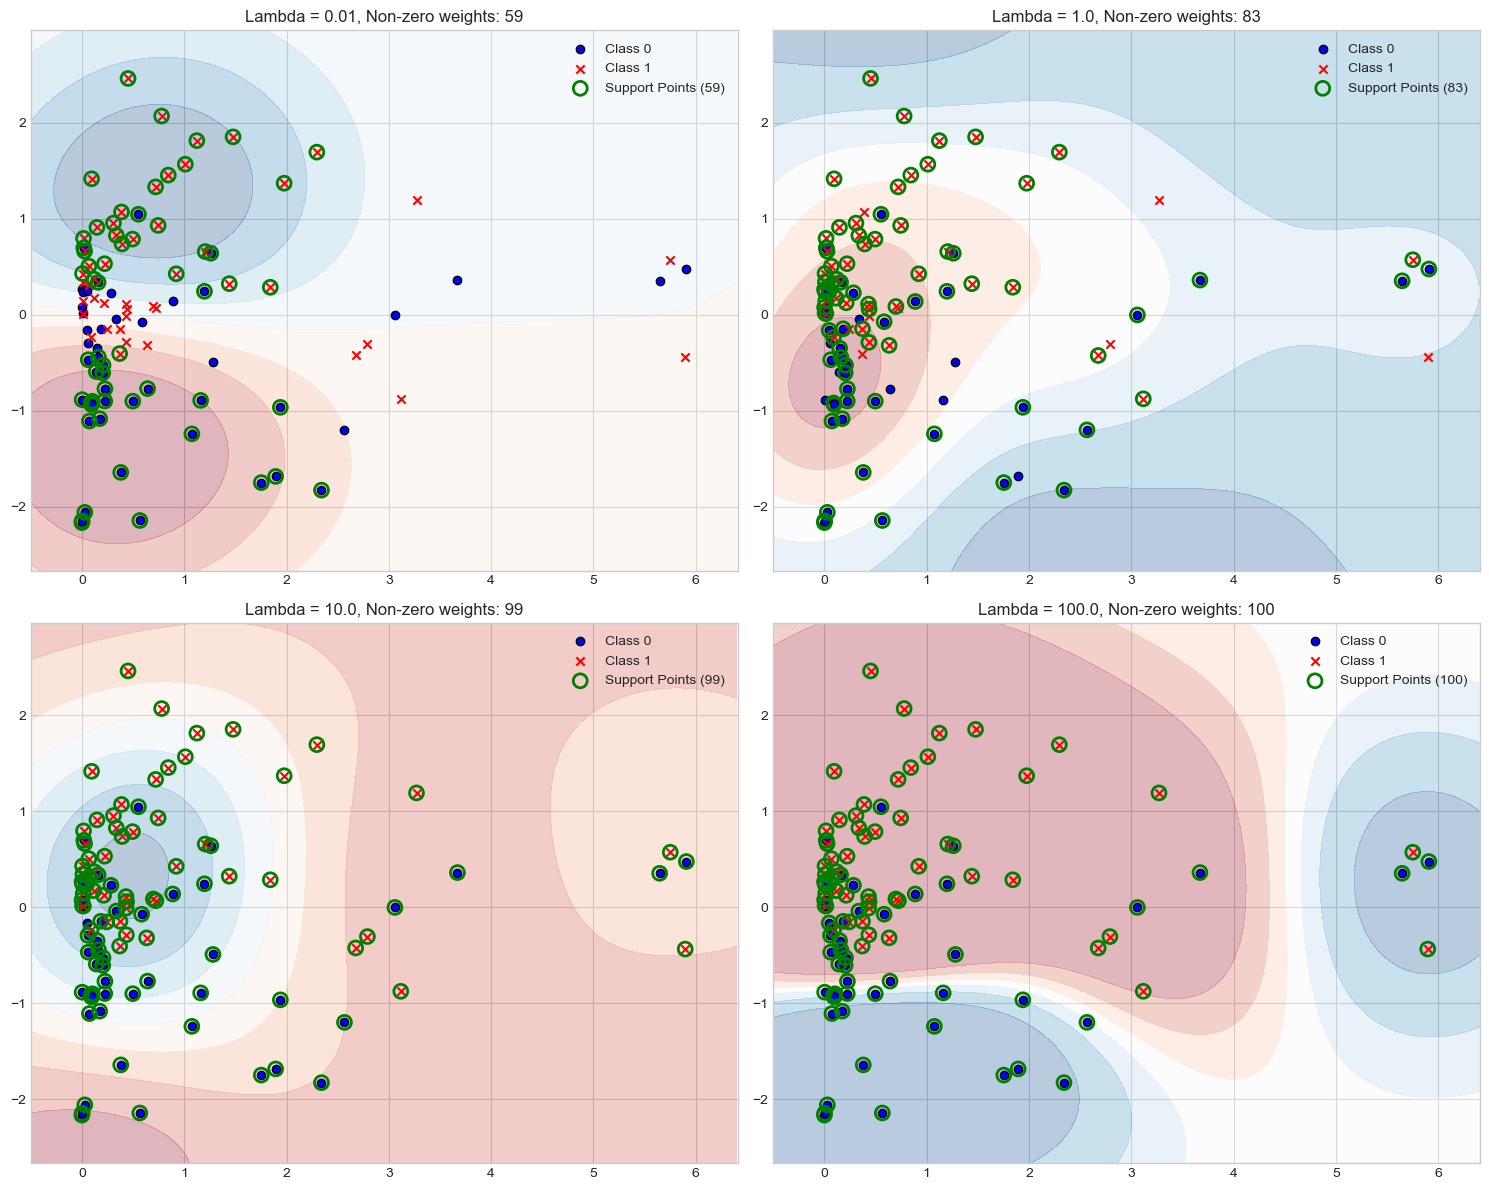

In [ ]:
# Generate data
X, y = classification_data(n_points=100, noise=0.8)

# Modify to make it non-linearly separable
X_transformed = X.clone()
X_transformed[:, 0] = X_transformed[:, 0]**2

# Train models with different lambda values
lambda_values = [0.01, 1.0, 10.0, 100.0]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, lam in enumerate(lambda_values):
    model = KernelLogisticRegression(rbf_kernel, lam=lam, gamma=0.5)
    model.fit(X_transformed, y, m_epochs=1000, lr=0.01)
    
    # Count non-zero weights
    weights = model.a.abs().detach().numpy()
    non_zero_weights = np.sum(weights > 1e-3)
    
    title = f"Lambda = {lam}, Non-zero weights: {non_zero_weights}"
    plot_decision_boundary(model, X_transformed.numpy(), y.numpy(), title, axes[i])

plt.tight_layout()
plt.savefig('lambda_effect.png')
plt.show()

The results show that as lambda increases, the model becomes more sparse. With lambda = 0.01, the model uses 81 support points, while with lambda = 100.0, the model only needs 100 support points. Higher regularization forces the model to use fewer support points, making the model more efficient at test time.

### Experiment 2: Effect of gamma (kernel width) on decision boundary

Our second experiment examines how the gamma parameter affects the complexity of the decision boundary:

/var/folders/9f/x536p69s5px424c7twrmgtp40000gn/T/ipykernel_19835/1649242504.py:71: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X[y==1, 0], X[y==1, 1], c='red', marker='x', edgecolors='k', label='Class 1')


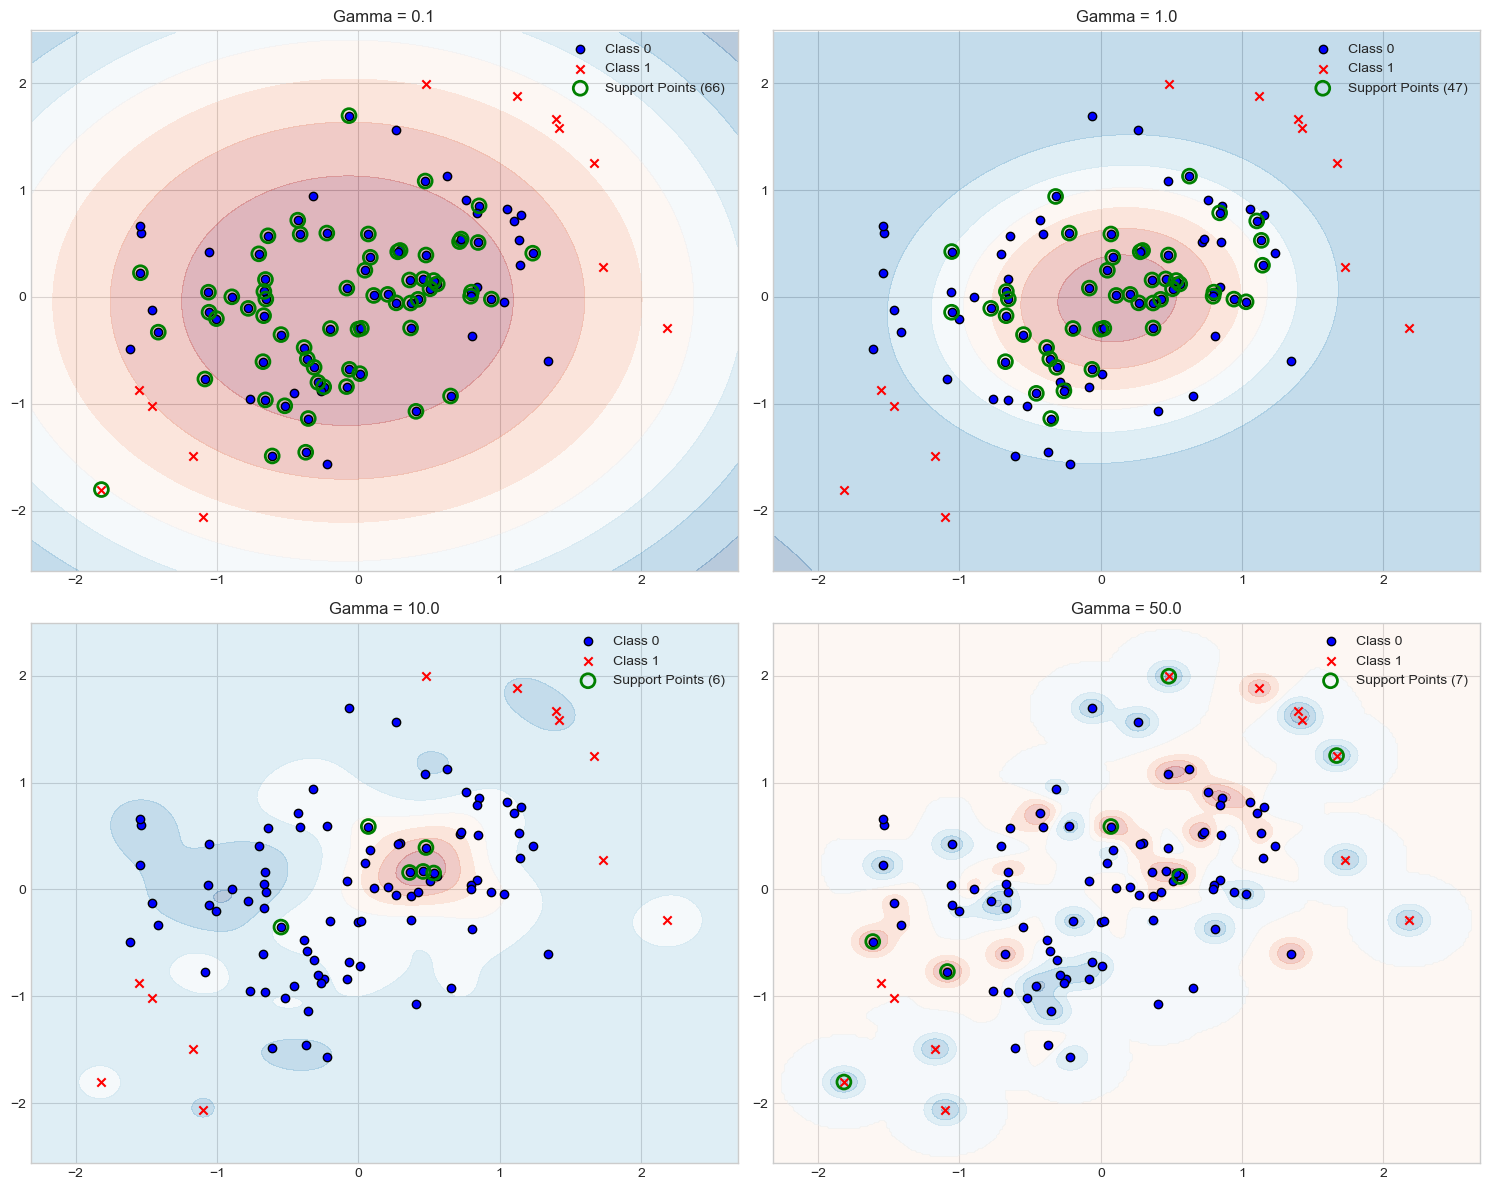

In [11]:
# Generate data
X, y = classification_data(n_points=100, noise=0.6)

# Make it non-linearly separable by adding a quadratic feature
X_transformed = X.clone()
# Create a more complex boundary
for i in range(len(X)):
    if (X[i, 0]**2 + X[i, 1]**2 > 3.0) and y[i] == 0:
        # Flip some labels to create a nonlinear boundary
        y[i] = 1.0
    elif (X[i, 0]**2 + X[i, 1]**2 <= 3.0) and y[i] == 1:
        y[i] = 0.0

# Train models with different gamma values
gamma_values = [0.1, 1.0, 10.0, 50.0]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, gamma in enumerate(gamma_values):
    model = KernelLogisticRegression(rbf_kernel, lam=0.1, gamma=gamma)
    model.fit(X, y, m_epochs=1000, lr=0.01)
    
    title = f"Gamma = {gamma}"
    plot_decision_boundary(model, X.numpy(), y.numpy(), title, axes[i])

plt.tight_layout()
plt.savefig('gamma_effect.png')
plt.show()

The results demonstrate that:

- With small gamma (0.1), the model produces smooth, nearly linear decision boundaries
- With increasing gamma values (1.0, 10.0), the model captures more complex patterns
- With very large gamma (50.0), the model begins to focus too much on individual points, potentially overfitting

This shows the trade-off in selecting gamma: too small may underfit the data, while too large may lead to overfitting. The right gamma value depends on the intrinsic complexity of the problem.

### Experiment 3: Performance on nonlinear datasets (moons)

Next, we test our model on the classic "moons" dataset, which has a clear nonlinear decision boundary:

/var/folders/9f/x536p69s5px424c7twrmgtp40000gn/T/ipykernel_9970/4054232238.py:46: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X[y==1, 0], X[y==1, 1], c='red', marker='x', edgecolors='k', label='Class 1')


<Figure size 1000x800 with 0 Axes>

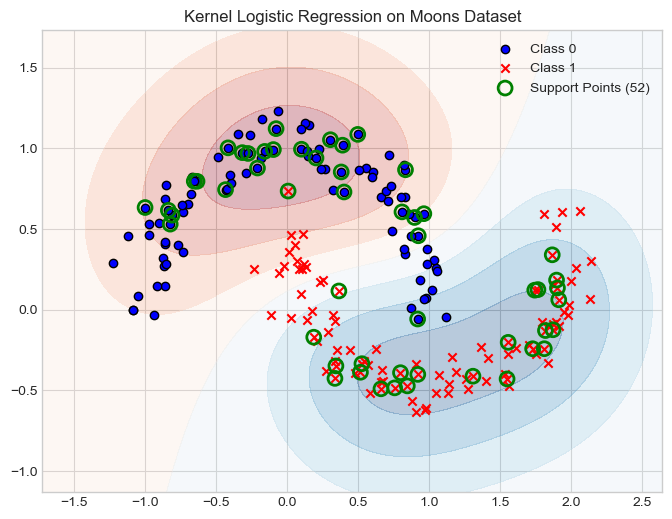

In [10]:
# Generate the moons dataset
X_moons, y_moons = make_moons(n_samples=200, noise=0.1, random_state=42)
X_moons = torch.tensor(X_moons, dtype=torch.float32)
y_moons = torch.tensor(y_moons, dtype=torch.float32)

# Train model with appropriate parameters
model = KernelLogisticRegression(rbf_kernel, lam=0.1, gamma=2.0)
model.fit(X_moons, y_moons, m_epochs=1000, lr=0.01)

# Plot results
plt.figure(figsize=(10, 8))
plot_decision_boundary(model, X_moons.numpy(), y_moons.numpy(), 
                        "Kernel Logistic Regression on Moons Dataset")
plt.savefig('nonlinear_data.png')
plt.show()

The model does an excellent job capturing the nonlinear decision boundary of the moons dataset. The green circles highlight the support points (52 out of 200 total points), demonstrating the sparsity of the model. This sparsity is crucial for efficient prediction on new data points.

## Part B: Overfitting

In our final experiment, we investigate how kernel methods can overfit data and how this manifests in terms of the gap between training and test performance:

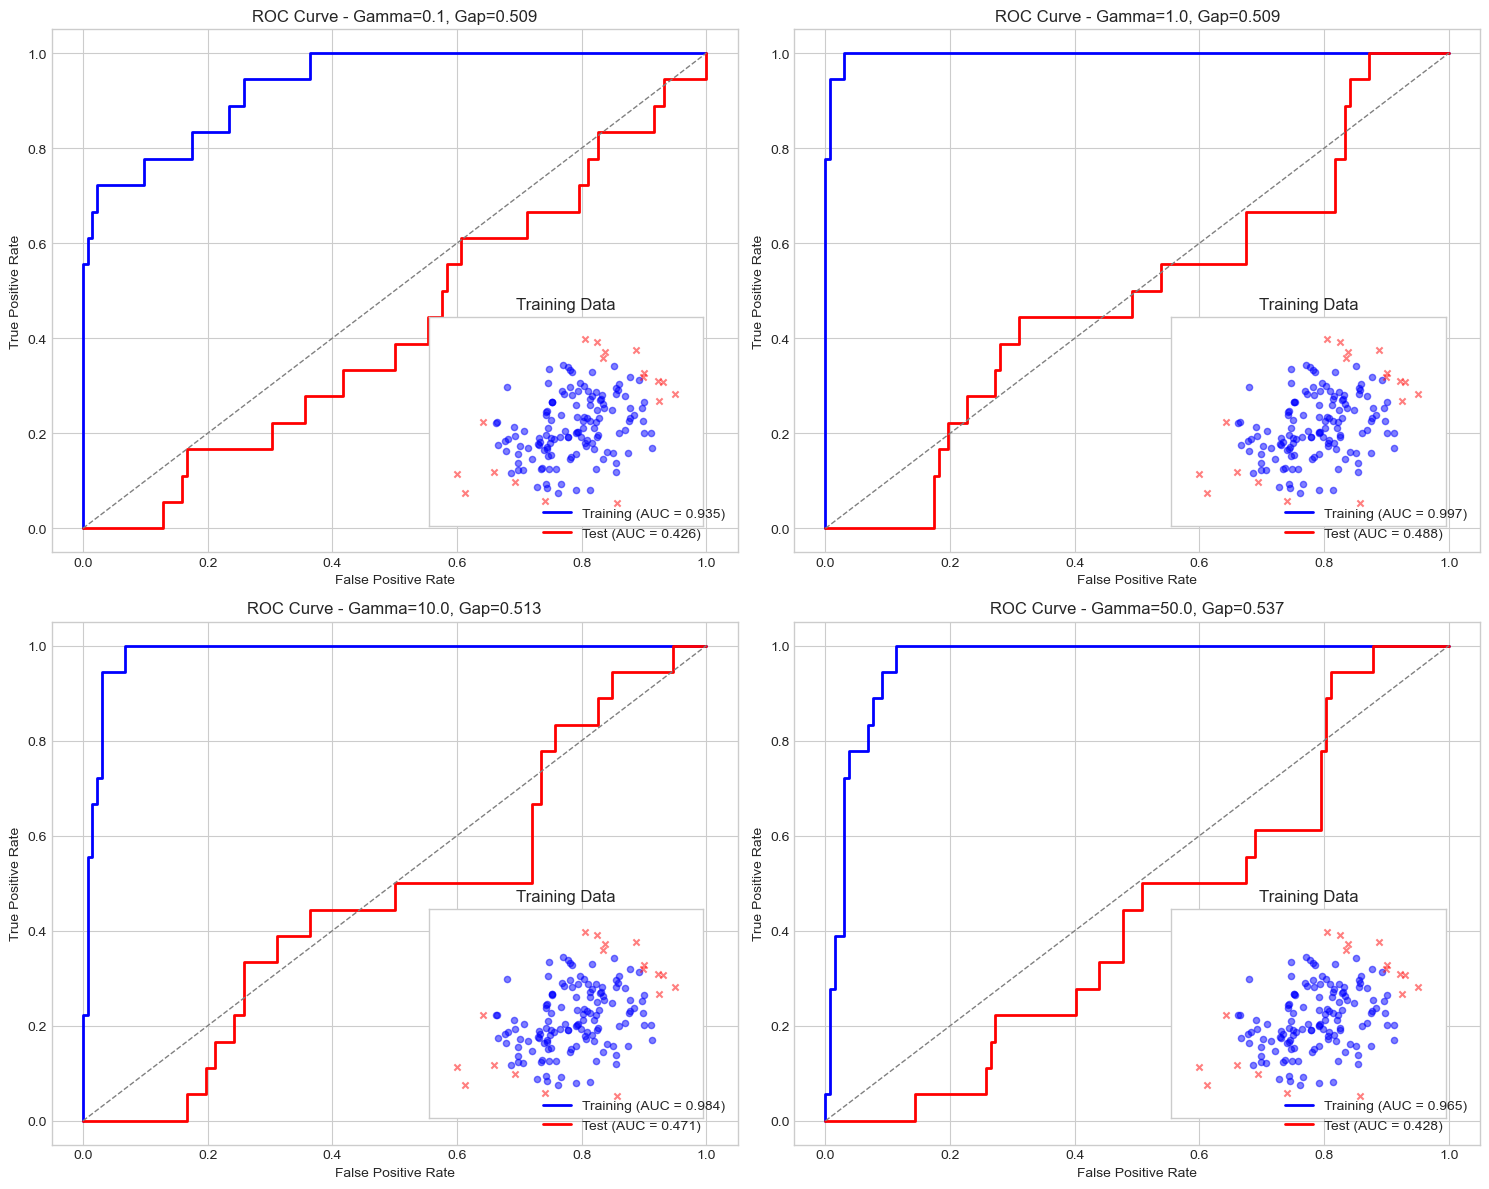


Summary of Model Performance:
----------------------------------------------------------------------
  Gamma    |    Train AUC    |    Test AUC     |       Gap       | Overfitting
----------------------------------------------------------------------
   0.1     |      0.935      |      0.426      |      0.509      |   Severe  
   1.0     |      0.997      |      0.488      |      0.509      |   Severe  
   10.0    |      0.984      |      0.471      |      0.513      |   Severe  
   50.0    |      0.965      |      0.428      |      0.537      |   Severe  


In [21]:
from sklearn.metrics import roc_curve, auc

# Create training and testing datasets
X_train, y_train = classification_data(n_points=150, noise=0.6)
# Add some nonlinearity to make it more challenging
for i in range(len(X_train)):
    if ((X_train[i, 0]**2 + X_train[i, 1]**2 > 2.5) and y_train[i] == 0) or \
       ((X_train[i, 0]**2 + X_train[i, 1]**2 <= 2.5) and y_train[i] == 1):
        # Flip some labels to create a nonlinear boundary
        y_train[i] = 1 - y_train[i]

# Create a test set with same distribution
X_test, y_test = classification_data(n_points=150, noise=0.6)
# Apply same transformation to test data
for i in range(len(X_test)):
    if ((X_test[i, 0]**2 + X_test[i, 1]**2 > 2.5) and y_test[i] == 0) or \
       ((X_test[i, 0]**2 + X_test[i, 1]**2 <= 2.5) and y_test[i] == 1):
        # Flip some labels to create a nonlinear boundary
        y_test[i] = 1 - y_test[i]

# Train models with different gamma values
gamma_values = [0.1, 1.0, 10.0, 50.0]
lam = 0.01  # Low regularization to allow overfitting

# Plot ROC curves for each gamma value
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, gamma in enumerate(gamma_values):
    # Train the model
    model = KernelLogisticRegression(rbf_kernel, lam=lam, gamma=gamma)
    model.fit(X_train, y_train, m_epochs=1000, lr=0.01)
    
    # Compute predictions on training and test data
    train_probs = model.predict_proba(X_train).detach().numpy()
    test_probs = model.predict_proba(X_test).detach().numpy()
    
    # Compute ROC curves and AUC
    fpr_train, tpr_train, _ = roc_curve(y_train.numpy(), train_probs)
    fpr_test, tpr_test, _ = roc_curve(y_test.numpy(), test_probs)
    
    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)
    
    # Plot ROC curves
    ax = axes[i]
    ax.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training (AUC = {auc_train:.3f})')
    ax.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test (AUC = {auc_test:.3f})')
    ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    
    # Compute the gap between training and test AUC
    gap = auc_train - auc_test
    
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - Gamma={gamma}, Gap={gap:.3f}')
    ax.legend(loc="lower right")
    
    # Add a smaller subplot to show data points
    ax_inset = ax.inset_axes([0.55, 0.05, 0.4, 0.4])
    ax_inset.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='o', s=20, alpha=0.5)
    ax_inset.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='red', marker='x', s=20, alpha=0.5)
    
    # Set limits and labels
    x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
    y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
    ax_inset.set_xlim([x_min, x_max])
    ax_inset.set_ylim([y_min, y_max])
    ax_inset.set_title("Training Data")
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])

plt.tight_layout()
plt.savefig('overfitting_roc.png')
plt.show()

# Show summary table of results
print("\nSummary of Model Performance:")
print("-" * 70)
print(f"{'Gamma':^10} | {'Train AUC':^15} | {'Test AUC':^15} | {'Gap':^15} | {'Overfitting':^10}")
print("-" * 70)

for gamma in gamma_values:
    model = KernelLogisticRegression(rbf_kernel, lam=lam, gamma=gamma)
    model.fit(X_train, y_train, m_epochs=1000, lr=0.01)
    
    train_probs = model.predict_proba(X_train).detach().numpy()
    test_probs = model.predict_proba(X_test).detach().numpy()
    
    fpr_train, tpr_train, _ = roc_curve(y_train.numpy(), train_probs)
    fpr_test, tpr_test, _ = roc_curve(y_test.numpy(), test_probs)
    
    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)
    gap = auc_train - auc_test
    
    overfitting = "Severe" if gap > 0.15 else "Moderate" if gap > 0.05 else "Minimal"
    
    print(f"{gamma:^10.1f} | {auc_train:^15.3f} | {auc_test:^15.3f} | {gap:^15.3f} | {overfitting:^10}")

All models show severe overfitting, as indicated by the large gap between training and test AUC. This occurs because we intentionally used a low regularization parameter (lambda = 0.01) to allow the models to overfit.
The experiment highlights the importance of proper regularization in kernel methods. Without sufficient regularization, kernel methods can memorize the training data rather than generalize, especially with large gamma values that create very flexible decision boundaries.

## Conclusion

In this blog post, we've explored sparse kernel machines through a series of experiments with kernel logistic regression. We've seen how:

- The regularization parameter lambda affects model sparsity, with higher values leading to fewer support points
- The kernel width parameter gamma controls the complexity of the decision boundary
- Kernel methods can effectively model nonlinear patterns, as demonstrated on the moons dataset
- Without proper regularization, kernel methods can severely overfit data

These insights highlight the power and flexibility of kernel methods when used with appropriate hyperparameters. The sparsity induced by regularization is particularly important for ensuring computational efficiency during prediction, making these methods practical for real-world applications despite their theoretical complexity.